In [1]:
"""
Data preparation for PPI dataset

database = {'costs': a list of adjacency matrices of different graphs,
            'probs': a list of distributions of nodes in different graphs,
            'idx2nodes': a list of dictionaries mapping index to node name,
            'correspondence': None or a list of correspondence set}
"""

import methods.EvaluationMeasure as Eval
import methods.GromovWassersteinGraphToolkit as GwGt
import pickle
import time
import warnings

warnings.filterwarnings("ignore")


with open('data/PPI_syn_database.pkl', 'rb') as f:
    database = pickle.load(f)

num_iter = 2000
ot_dict = {'loss_type': 'L2',  # the key hyperparameters of GW distance
           'ot_method': 'proximal',
           'beta': 0.025,
           'outer_iteration': num_iter,
           # outer, inner iteration, error bound of optimal transport
           'iter_bound': 1e-30,
           'inner_iteration': 2,
           'sk_bound': 1e-30,
           'node_prior': 1e3,
           'max_iter': 4,  # iteration and error bound for calcuating barycenter
           'cost_bound': 1e-26,
           'update_p': False,  # optional updates of source distribution
           'lr': 0,
           'alpha': 0}

for i in range(5):
    cost_s = database['costs'][0]
    cost_t = database['costs'][i+1]
    p_s = database['probs'][0]
    p_t = database['probs'][i+1]
    idx2node_s = database['idx2nodes'][0]
    idx2node_t = database['idx2nodes'][i+1]
    num_nodes = min([len(idx2node_s), len(idx2node_t)])

    time_s = time.time()
    ot_dict['outer_iteration'] = num_iter
    pairs_idx, pairs_name, pairs_confidence = GwGt.direct_graph_matching_netotc(
        0.5 * (cost_s + cost_s.T), 0.5 * (cost_t + cost_t.T), p_s, p_t, idx2node_s, idx2node_t, ot_dict)
    runtime = time.time() - time_s
    nc = Eval.calculate_node_correctness(pairs_name, num_correspondence=num_nodes)
    print('method: NetOTC, duration {:.4f}s, nc {:.4f}.'.format(runtime, nc))
    with open('results/gwl_ppi_syn_{}.pkl'.format(i + 1), 'wb') as f:
        pickle.dump([nc, runtime], f)
    time_s = time.time()
    
    
    ot_dict['outer_iteration'] = num_iter
    pairs_idx, pairs_name, pairs_confidence = GwGt.direct_graph_matching(
        0.5 * (cost_s + cost_s.T), 0.5 * (cost_t + cost_t.T), p_s, p_t, idx2node_s, idx2node_t, ot_dict)
    runtime = time.time() - time_s
    nc = Eval.calculate_node_correctness(pairs_name, num_correspondence=num_nodes)
    print('method: gwl, duration {:.4f}s, nc {:.4f}.'.format(runtime, nc))
    with open('results/gwl_ppi_syn_{}.pkl'.format(i + 1), 'wb') as f:
        pickle.dump([nc, runtime], f)

    # time_s = time.time()
    # ot_dict['outer_iteration'] = num_iter
    # pairs_idx, pairs_name, pairs_confidence = GwGt.recursive_direct_graph_matching(
    #     0.5 * (cost_s + cost_s.T), 0.5 * (cost_t + cost_t.T), p_s, p_t, idx2node_s, idx2node_t, ot_dict,
    #     weights=None, predefine_barycenter=False, cluster_num=2,
    #     partition_level=3, max_node_num=0)
    # runtime = time.time() - time_s
    # nc = Eval.calculate_node_correctness(pairs_name, num_correspondence=num_nodes)
    # print('method: s-gwl, duration {:.4f}s, nc {:.4f}.'.format(runtime, nc))
    # with open('results/sgwl_ppi_syn_{}.pkl'.format(i + 1), 'wb') as f:
    #     pickle.dump([nc, runtime], f)


# 转换成稠密矩阵
cost_s_dense = 0.5 * (cost_s + cost_s.T).todense()
cost_t_dense = 0.5 * (cost_t + cost_t.T).todense()

# 保存变量
with open('graph_data_lollipop.pkl', 'wb') as f:
    pickle.dump({
        'cost_s_dense': cost_s_dense,
        'cost_t_dense': cost_t_dense,
        'pairs_idx': pairs_idx,
        'idx2node_s': idx2node_s,
        'idx2node_t': idx2node_t
    }, f)

print("变量已保存")

MemoryError: Unable to allocate 7.39 TiB for an array with shape (1008016, 1008016) and data type float64

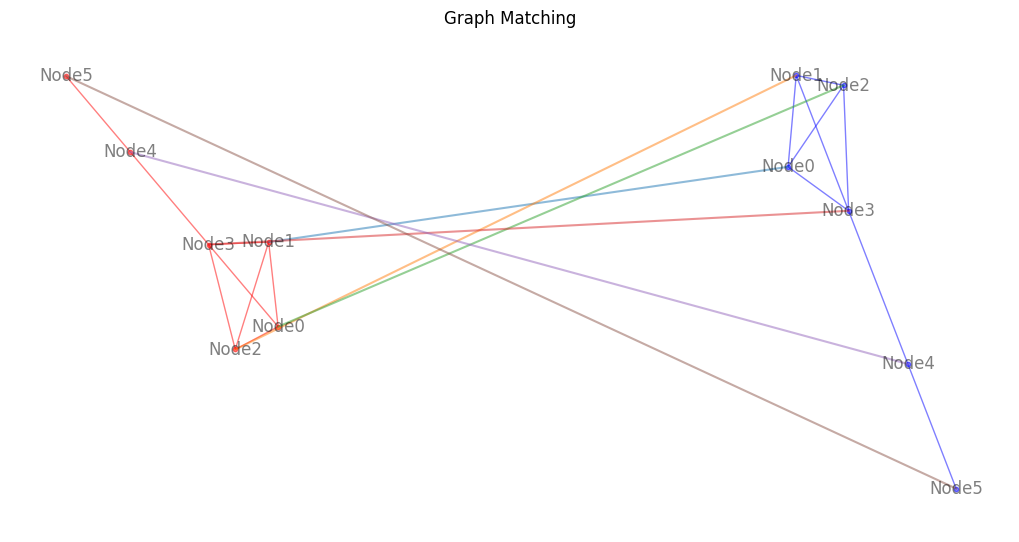

In [ ]:
# 加载保存的变量
with open('graph_data_lollipop.pkl', 'rb') as f:
    data = pickle.load(f)

cost_s_dense = data['cost_s_dense']
cost_t_dense = data['cost_t_dense']
pairs_idx = data['pairs_idx']
idx2node_s = data['idx2node_s']
idx2node_t = data['idx2node_t']
def visualize_match(cost_s, cost_t, matches, idx2node_s, idx2node_t, title="Graph Matching"):
    # 创建两个图形
    G_s = nx.from_numpy_array(cost_s)
    G_t = nx.from_numpy_array(cost_t)
    plt.figure(figsize=(10, 5))
    # 为了在一个平面上可视化两个图，我们把它们的位置稍微分开
    pos_s = nx.spring_layout(G_s)  # source图形的位置
    pos_t = {i: (x + 5, y) for i, (x, y) in enumerate(nx.spring_layout(G_t).values())}  # target图形的位置，我们通过加上一个固定的值来将其移开

    # 开始绘制source图形
    nx.draw(G_s, pos_s, with_labels=True, node_color='r', edge_color='r', node_size=10, alpha=0.5, labels=idx2node_s)

    # 绘制target图形
    nx.draw(G_t, pos_t, with_labels=True, node_color='b', edge_color='b', node_size=10, alpha=0.5, labels=idx2node_t)

    # 绘制匹配的边
    for s_idx, t_idx in matches:
        plt.plot([pos_s[s_idx][0], pos_t[t_idx][0]], [pos_s[s_idx][1], pos_t[t_idx][1]], alpha=0.5)

    plt.title(title)
    plt.show()
# 假设 cost_s 和 cost_t 是你的图形邻接矩阵，已经转换为稠密格式
# pairs_idx 是一个包含匹配对的列表，例如 [(0, 2), (1, 3), ...]
# idx2node_s 和 idx2node_t 是索引到节点名的映射字典

# 调用可视化函数
visualize_match(cost_s_dense, cost_t_dense, pairs_idx, idx2node_s, idx2node_t)


In [ ]:
cost_s.todense()

array([[0, 1, 1, 1, 0, 0],
       [1, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0]])

In [ ]:
np.array(list(nx.spring_layout(nx.from_numpy_array(cost_s)).values()))

array([[ 0.35387187, -0.32444965],
       [ 0.46995718,  0.09751352],
       [ 0.60664487, -0.1670193 ],
       [ 0.08424714, -0.02328149],
       [-0.51472107,  0.14171981],
       [-1.        ,  0.27551711]])

NameError: name 'pos_s' is not defined

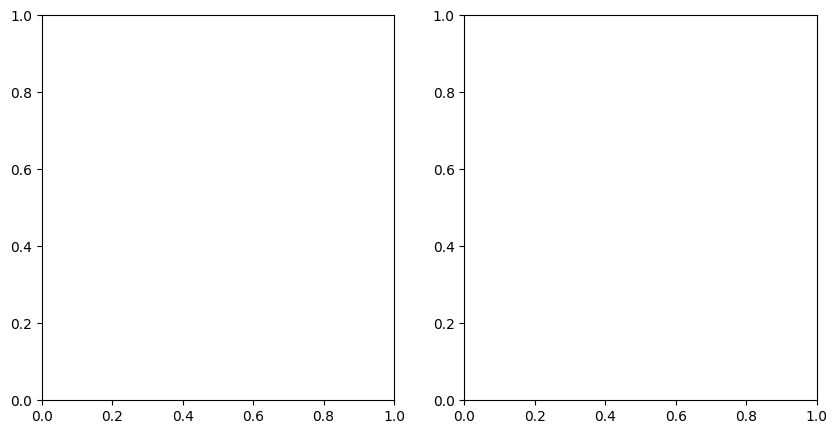

In [ ]:
def plot_graph(A, V, ax, color, title):
    # Plot edges
    scale_A = 4*((A - np.min(A)) / np.max(A))
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            weight = scale_A[i, j]
            if weight > 0:
                ax.plot([V[i, 0], V[j, 0]], [V[i, 1], V[j, 1]], color=color, lw=weight, alpha=0.5)
    
    # Plot vertices
    ax.scatter(V[:, 0], V[:, 1], c='black', s=20, zorder=5)
    
    # Annotate vertices
    for i, txt in enumerate(range(V.shape[0])):
        ax.annotate(txt, (V[i, 0], V[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')
    
    ax.set_title(title)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_graph(cost_s_dense, np.array(list(pos_s.values())), ax[0], color='r', title='Source Graph')